In [1]:
import numpy as np
import lmfit as lm
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
import os
import re

def get_degrees(filename):
    """Извлекаем угол из имени файла"""
    degstring = re.search(r"(?<=-2x)\d+(\-)?\d*(?=deg)", filename)[0].replace('-', '.')
    return float(degstring)
               
working_dir = os.getcwd() + "/data/"
filenames = list(filter(lambda f: ".txt" in f, os.listdir(working_dir))) # Работаем только с .txt
filenames.sort(key=get_degrees)

In [3]:
def cut_range(data, startx, endx):
    """Ограничиваем диапазон"""
    xdata = data[:,0]
    if startx <= endx:
        condition = (startx <= xdata) & (xdata <= endx)
    else:
        condition = (startx > xdata) & (xdata > endx)
    return data[condition]

def make_zeros(data, cutout):
    """Заменяем кусочек диапазона нулями - СЕЙЧАС НЕ НУЖНО"""
    newdata = data
    xdata = data[:,0]
    condition = (cutout[0] <= xdata) & (cutout[1] >= xdata)
    newdata[condition, 1] = min(data[:,1])
    return newdata

In [4]:
def find_closest(point, data):
    """Найти точку в массиве, ближайшую к заданной"""
    xdata = list(data[:,0])
    return sorted(xdata, key=lambda x: abs(x-point))[0]


In [5]:
def fit_peaks(data):
    """Подогнать кривые к данным"""
    p = 87
    p_parasite = 121
    wcenter = 2
    acenter = max(data[:,1]) * wcenter * np.pi/2
    wshift = 15
    stokes_a = data[np.where(data[:,0] == find_closest(p, data))[0][0], 1] * wshift * np.pi/2
    stokes_parasite_a = data[np.where(data[:,0] == find_closest(p_parasite, data))[0][0], 1] * wshift * np.pi/2
    antistokes_a = data[np.where(data[:,0] == find_closest(-p, data))[0][0], 1] * wshift * np.pi/2
    antistokes_parasite_a = data[np.where(data[:,0] == find_closest(-p_parasite, data))[0][0], 1] * wshift * np.pi/2

    stokes = lm.models.PseudoVoigtModel(prefix='stokes_')
    stokes_parasite = lm.models.PseudoVoigtModel(prefix='stokes_parasite_')
    antistokes = lm.models.PseudoVoigtModel(prefix='antistokes_')
    antistokes_parasite = lm.models.PseudoVoigtModel(prefix='antistokes_parasite_')
    center = lm.models.PseudoVoigtModel(prefix='center_')
    base = lm.models.LinearModel(prefix='base_')
    
    combined = stokes + stokes_parasite + antistokes + antistokes_parasite + base + center
    combined_params = combined.make_params(
        stokes_center=dict(value=p, min=p-1, max=p+1),
        stokes_amplitude=dict(value=stokes_a, min=stokes_a*0.9, max=stokes_a*1.1),
        stokes_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        stokes_parasite_center=dict(value=p_parasite, min=p_parasite-1, max=p_parasite+1),
        stokes_parasite_amplitude=dict(value=stokes_parasite_a, min=stokes_parasite_a*0.9, max=stokes_parasite_a*1.1),
        stokes_parasite_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        antistokes_center=dict(value=-p, min=-p-1, max=-p+1),
        antistokes_amplitude=dict(value=antistokes_a, min=antistokes_a*0.9, max=antistokes_a*1.1),
        antistokes_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        antistokes_parasite_center=dict(value=-p_parasite, min=-p_parasite-1, max=-p_parasite+1),
        antistokes_parasite_amplitude=dict(value=antistokes_parasite_a, min=antistokes_parasite_a*0.9, max=antistokes_parasite_a*1.1),
        antistokes_parasite_sigma=dict(value=wshift/2, min=(wshift-7)/2, max=(wshift+7)/2),

        center_center=0,
        center_amplitude=acenter,
        center_sigma=wcenter/2,

        base_slope = 0,
        base_intercept=min(data[:,1])
    )

    return combined.fit(data[:,1], combined_params, x=data[:,0])

In [6]:
laser_wavelength = 532 * 10**(-9)
raman_shift = 87 * 10**2
c = 3 # * 10**8
k = 1.381 # * 10**(-23)
h = 6.626 # * 10**(-34)

laser_freq = c / laser_wavelength
vibrational_freq = c * raman_shift

def calculate_temperature(I_s, I_as):

    fraction = (laser_freq - vibrational_freq)**3 / (laser_freq + vibrational_freq)**3 * I_as / I_s
    return -h*vibrational_freq / (k*np.log(fraction)) / 10**3 # Деление на 1000 эквивалентно учёту степеней 10 константах!

14. Соотношение I_as/I_s: 0.715
Градусы: 120, Температура: 344.13


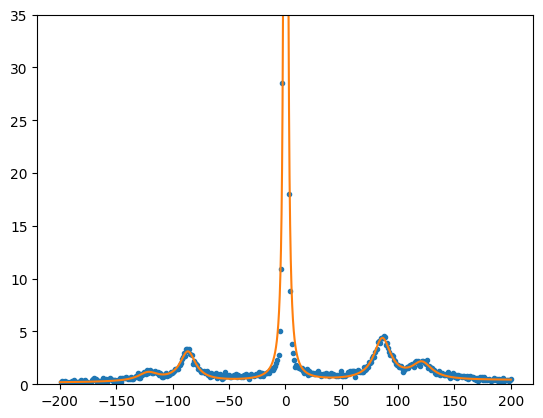

In [ ]:
START = -200
END = 200
CUTOUT = [-40, 40]

ax = plt.gca()

table = pd.DataFrame(columns=['Angle', 'I_S', 'I_AS', 'Temperature'])

count = 0
for filename in filenames:
    degrees = int(2 * float(get_degrees(filename)))
    count += 1
    if count != 14:
        continue
        2 == 2
    data = cut_range(np.loadtxt(working_dir + filename), START, END)

    fit = fit_peaks(data)
    fit_parameters = fit.params.valuesdict()
    I_stokes = fit_parameters['stokes_height']
    I_antistokes = fit_parameters['antistokes_height']
    print(f"{count}. Соотношение I_as/I_s: {I_antistokes/I_stokes:0.3f}")

    smooth_x = np.arange(START, END, 0.0001)
    smooth_data = np.transpose(np.array([smooth_x, fit.eval(x=smooth_x)]))

    ax.set_ylim([0, 35])
    plt.plot(*np.transpose(data), '.')
    plt.plot(*np.transpose(smooth_data))

    temperature = calculate_temperature(I_stokes, I_antistokes)
    row = (degrees, I_stokes, I_antistokes, temperature)
    table.loc[len(table)] = row

    print(f"Градусы: {degrees}, Температура: {temperature:0.2f}")
    print("="*20)

In [8]:
table.to_csv('output.csv', index=False)

$$\frac{I_{AS}}{I_S} = \frac{(\nu_L + \nu_v)^3}{(\nu_L - \nu_v)^3}\exp\left(\frac{-h\nu_v}{kT}\right) \iff
T = -\frac{h\nu_v}{k\ln\left(\frac{I_{AS}(\nu_L - \nu_v)^3}{I_S(\nu_L + \nu_v)^3}\right)}
$$